In [2]:
# константы
DATA_ROOT = "data/oxford"
BREEDS = ["Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair", "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll", "Russian_Blue", "Siamese", "Sphynx"]
CLASSES_NUM = len(BREEDS)
CAT_IMAGES = DATA_ROOT + "/cat_images"
IMG_SIZE = 299

# извлечение породы из названия файла
def breed_name_extract(title):
    str = title.lower()
    last_index = str.rfind('_')
    return str[:last_index]

In [4]:
# извлечение изображений кошек
import os
import shutil

path_to_images = DATA_ROOT + "/images/images"

if not os.path.exists(CAT_IMAGES):
    os.makedirs(CAT_IMAGES)

for breed in BREEDS:
    for file_name in os.listdir(path_to_images):
        if file_name.startswith(breed):
            shutil.move(os.path.join(path_to_images, file_name), CAT_IMAGES)

In [42]:
# эти изображения некорректно открываются
incorrect = {'Abyssinian_34.jpg', 'Egyptian_Mau_145.jpg', 'Egyptian_Mau_139.jpg', 'Egyptian_Mau_191.jpg', 'Egyptian_Mau_177.jpg', 'Egyptian_Mau_167.jpg'}
# удаление некорректных файлов
for file_name in os.listdir(CAT_IMAGES):
    if not file_name.endswith('jpg') or file_name in incorrect:
        os.remove(os.path.join(CAT_IMAGES, file_name))

In [3]:
# сбор id и пород из файла с аннотациями 

# получение информации из файла list.txt
annotations = open(DATA_ROOT + '/annotations/annotations/list.txt', 'r')

# информация об изображении
data_image = {}
# информация о породе
data_breed = {}

for line in annotations:
    if line[0] == '#':
        continue

    line = line.strip().split(' ')
    
    # коты = 1, собаки = 2
    species = int(line[2])
    if species == 2:
        continue
    
    # название изображения (без расширения)
    image = line[0].lower()
    
    breed_name = breed_name_extract(image)

    breed_id = int(line[3])

    data_image[image] = {'breed' : breed_name, 'breedid' : breed_id}
    if breed_id not in data_breed:
        data_breed[breed_id] = {'breed' : breed_name, 'count' : int(0)}
    else:
        data_breed[breed_id] = {'breed' : breed_name, 'count' : int(data_breed[breed_id]['count']+1)}
    
breeds_keys = list(data_breed.keys())

# количество по каждой породе
breeds_counts = [data_breed[key]['count'] for key in breeds_keys]

# название каждой породы
breeds = [data_breed[key]['breed'] for key in breeds_keys]

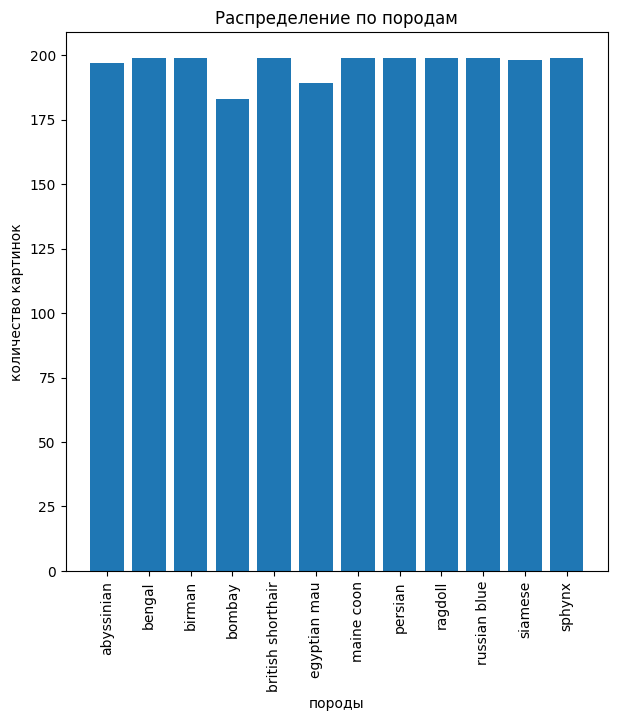

In [4]:
# графики по количеству кошек в каждой породе
import matplotlib.pyplot as plt

# замена нижнего подчёркивания ('_') на пробелы
breeds_labels = [breed.replace('_', ' ') for breed in breeds]

fig, ax = plt.subplots( figsize= (7,7))
ax.bar(breeds_keys, breeds_counts)

# set ticks and axis labels and legend:
ax.set_xticks(breeds_keys)
ax.set_xticklabels(breeds_labels, rotation='vertical')
plt.xlabel('породы')
plt.ylabel('количество картинок')
plt.title('Распределение по породам')
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.optimizers import Adam

def createModel(learning_rate=0.001, dropout=.25, img_size=IMG_SIZE, classes_num=CLASSES_NUM):
  input = tf.keras.Input(shape=(img_size, img_size, 3))
  layer = input
  
  inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
  inceptionV3.trainable = False

  layer = tf.keras.applications.inception_v3.preprocess_input(layer)
  layer = inceptionV3(layer, training=False)
  
  layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
  
  layer = tf.keras.layers.Dense(256, activation='relu')(layer)
  
  layer = tf.keras.layers.Dropout(dropout)(layer)
  
  layer = tf.keras.layers.BatchNormalization()(layer)
   
  output = tf.keras.layers.Dense(classes_num, activation='softmax')(layer)
  
  model = tf.keras.Model(input, output)
  
  model.summary()

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

  return model

2024-01-15 16:00:04.661655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 16:00:04.661743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 16:00:04.784877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 16:00:05.017636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 16:00:06.979639: W tensorflow/compiler/tf2

In [6]:
import random
import cv2
import numpy as np
import os

# получение номера класса по породе
breed_to_id = {}
for breed_id in data_breed:
    name = data_breed[breed_id]['breed']
    breed_to_id[name] = breed_id

# изображения после изменения размера
image_tensors = []
for image in os.listdir(CAT_IMAGES):
    print(image)
    # открыть файл в RGB формате 
    resized_images = cv2.imread(os.path.join(CAT_IMAGES, image))[...,::-1] 

    resized_images = cv2.resize(resized_images, (IMG_SIZE, IMG_SIZE))

    id = breed_to_id[breed_name_extract(image)]

    image_tensors.append([resized_images, id])

# перемешивание данные
random.shuffle(image_tensors)

training = list(zip(*image_tensors))
all_images = training[0]
all_labels = training[1]

all_images = np.array(all_images).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
all_labels = np.array(all_labels)

Abyssinian_1.jpg
Abyssinian_10.jpg
Abyssinian_100.jpg
Abyssinian_101.jpg
Abyssinian_102.jpg
Abyssinian_103.jpg
Abyssinian_104.jpg
Abyssinian_105.jpg
Abyssinian_106.jpg
Abyssinian_107.jpg
Abyssinian_108.jpg
Abyssinian_109.jpg
Abyssinian_11.jpg
Abyssinian_110.jpg
Abyssinian_111.jpg
Abyssinian_112.jpg
Abyssinian_113.jpg
Abyssinian_114.jpg
Abyssinian_115.jpg
Abyssinian_116.jpg
Abyssinian_117.jpg
Abyssinian_118.jpg
Abyssinian_119.jpg
Abyssinian_12.jpg
Abyssinian_120.jpg
Abyssinian_121.jpg
Abyssinian_122.jpg
Abyssinian_123.jpg
Abyssinian_124.jpg
Abyssinian_125.jpg
Abyssinian_126.jpg
Abyssinian_127.jpg
Abyssinian_128.jpg
Abyssinian_129.jpg
Abyssinian_13.jpg
Abyssinian_130.jpg
Abyssinian_131.jpg
Abyssinian_132.jpg
Abyssinian_133.jpg
Abyssinian_134.jpg
Abyssinian_135.jpg
Abyssinian_136.jpg
Abyssinian_137.jpg
Abyssinian_138.jpg
Abyssinian_139.jpg
Abyssinian_14.jpg
Abyssinian_140.jpg
Abyssinian_141.jpg
Abyssinian_142.jpg
Abyssinian_143.jpg
Abyssinian_144.jpg
Abyssinian_145.jpg
Abyssinian_146.jpg


In [13]:
# разделение данных на тестовые и обучающиеся
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels)

In [14]:
# горячее кодирование 
from sklearn.preprocessing import OneHotEncoder

def onehotencode(y):
  encoder = OneHotEncoder(sparse=False)
  integer_encoded = y.reshape(len(y), 1)
  encoder = encoder.fit_transform(integer_encoded)
  return encoder

In [15]:
# тестирование обучения модели
from sklearn.model_selection import StratifiedKFold
test_metrics = ['train_acc', 'train_loss', 'val_acc', 'val_loss']
test_keys = ['accuracy', 'loss', 'val_accuracy', 'val_loss']
test_metrics_to_names = {test_metrics[0] : 'Точность (обучение)', test_metrics[1] : 'Потери (обучение)', test_metrics[2] : 'Точность (проверка)', test_metrics[3] : 'Потери (проверка)'}
def test_training(learning_rate=0.001, dropout=0.25, epochs=15, batch_size=64):
  kfold = StratifiedKFold(n_splits=3, shuffle=True)
  folds = kfold.split(x_train, y_train)

  test_results = {}

  i = 0.0

  for train_index, val_index in folds:

    model = createModel(dropout=dropout, learning_rate=learning_rate)

    x_train_kf, x_val_kf =  x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = onehotencode(y_train[train_index]), onehotencode(y_train[val_index])

    temp = model.fit(x_train_kf, y_train_kf, batch_size=batch_size, epochs=epochs, validation_data=(x_val_kf, y_val_kf))

    del model

    isEmpty = test_results == {}
    for j in range(len(test_metrics)):
        if isEmpty:
            test_results[test_metrics[j]] = np.array(temp.history[test_keys[j]])
        else:
            test_results[test_metrics[j]] += np.array(temp.history[test_keys[j]])
    
    i+=1

  for k in test_results:
    # средние значения
    test_results[k] /= i

  return test_results

In [16]:
def draw_test_results(test_results):
    fig, axs = plt.subplots(figsize=(10,7))

    for metric in test_results:
        axs.plot(test_results[metric], label=test_metrics_to_names[metric])
        
    axs.set_xlabel('эпохи')
    axs.set_ylabel('значение')
    axs.legend(loc='upper right')

    fig.tight_layout()
    plt.show()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
18/18 [==============================] - 13s 432ms/step - loss: 0.9098 - accuracy: 0.7007 - val_loss: 1.3395 - val_accuracy: 0.7263
Epoch 2/5
18/18 [==============================] - 5s 301ms/step - loss: 0.4104 - accuracy: 0.8548 - val_loss: 1.2959 - val_accuracy: 0.7281
Epoch 3/5
18/18 [==============================] - 5s 297ms/step - loss: 0.2776 - accuracy: 0.9068 - val_loss: 0.4914 - val_accuracy: 0.8354
Epoch 4/5
18/18 [==============================] - 6s 319ms/step - loss: 0.2162 - accuracy: 0.9310 - val_loss: 0.5200 - val_accuracy: 0.8462
Epoch 5/5
18/18 [==============================] - 6s 317ms/step - loss: 0.1675 - accuracy: 0.9471 - val_loss: 0.6039 - val_accuracy: 0.8283
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.true

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
18/18 [==============================] - 15s 435ms/step - loss: 1.0598 - accuracy: 0.6473 - val_loss: 1.7332 - val_accuracy: 0.6487
Epoch 2/5
18/18 [==============================] - 5s 306ms/step - loss: 0.4372 - accuracy: 0.8460 - val_loss: 0.6603 - val_accuracy: 0.7975
Epoch 3/5
18/18 [==============================] - 5s 302ms/step - loss: 0.3180 - accuracy: 0.8774 - val_loss: 0.5770 - val_accuracy: 0.8154
Epoch 4/5
18/18 [==============================] - 5s 301ms/step - loss: 0.2220 - accuracy: 0.9194 - val_loss: 0.5399 - val_accuracy: 0.8423
Epoch 5/5
18/18 [==============================] - 5s 300ms/step - loss: 0.1693 - accuracy: 0.9338 - val_loss: 0.4004 - val_accuracy: 0.8674
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.true

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
18/18 [==============================] - 13s 434ms/step - loss: 1.0277 - accuracy: 0.6643 - val_loss: 1.6080 - val_accuracy: 0.6129
Epoch 2/5
18/18 [==============================] - 5s 305ms/step - loss: 0.4581 - accuracy: 0.8442 - val_loss: 0.5659 - val_accuracy: 0.8208
Epoch 3/5
18/18 [==============================] - 5s 308ms/step - loss: 0.3182 - accuracy: 0.8881 - val_loss: 0.5090 - val_accuracy: 0.8315
Epoch 4/5
18/18 [==============================] - 5s 298ms/step - loss: 0.2597 - accuracy: 0.9042 - val_loss: 0.5703 - val_accuracy: 0.8369
Epoch 5/5
18/18 [==============================] - 5s 299ms/step - loss: 0.1946 - accuracy: 0.9320 - val_loss: 0.4777 - val_accuracy: 0.8566


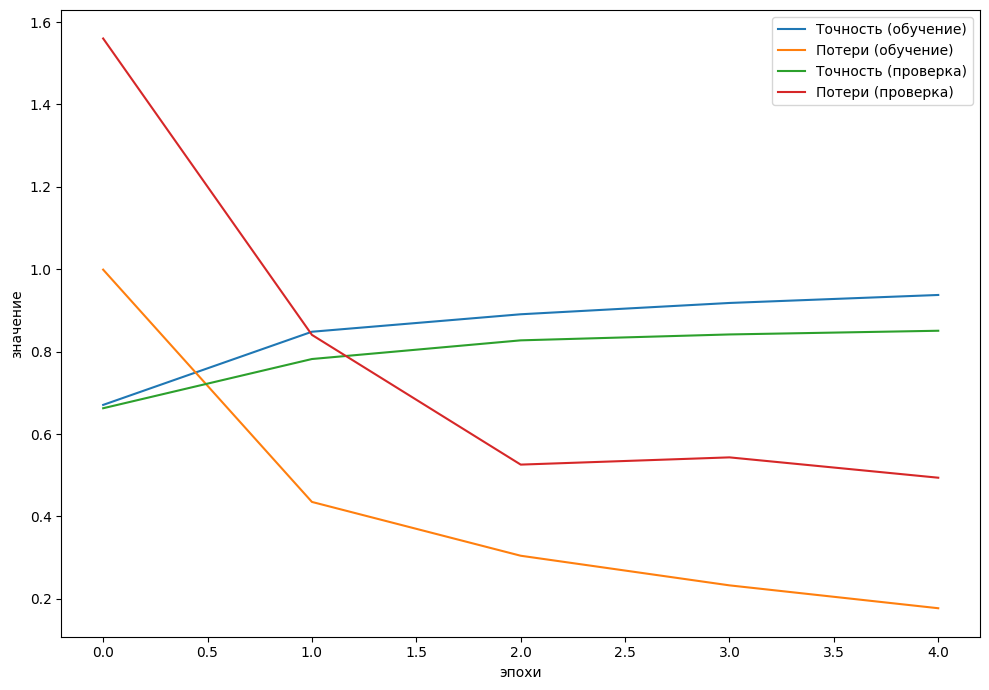

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_7 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_7 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 14s 428ms/step - loss: 0.9422 - accuracy: 0.6694 - val_loss: 2.4369 - val_accuracy: 0.5921
Epoch 2/10
18/18 [==============================] - 5s 300ms/step - loss: 0.4059 - accuracy: 0.8620 - val_loss: 0.6483 - val_accuracy: 0.8175
Epoch 3/10
18/18 [==============================] - 5s 302ms/step - loss: 0.2993 - accuracy: 0.8817 - val_loss: 0.5813 - val_accuracy: 0.8229
Epoch 4/10
18/18 [==============================] - 5s 304ms/step - loss: 0.2379 - accuracy: 0.9265 - val_loss: 0.5563 - val_accuracy: 0.8318
Epoch 5/10
18/18 [==============================] - 5s 302ms/step - loss: 0.2149 - accuracy: 0.9292 - val_loss: 0.5744 - val_accuracy: 0.8372
Epoch 6/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1885 - accuracy: 0.9346 - val_loss: 0.3988 - val_accuracy: 0.8730
Epoch 7/10
18/18 [==============================] - 5s 301ms/step - loss: 0.1411 - accuracy: 0.9525 - val_loss: 0.5896 - val_accuracy: 0.8283
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 420ms/step - loss: 1.0068 - accuracy: 0.6750 - val_loss: 0.8249 - val_accuracy: 0.8082
Epoch 2/10
18/18 [==============================] - 5s 300ms/step - loss: 0.4330 - accuracy: 0.8550 - val_loss: 0.7803 - val_accuracy: 0.8190
Epoch 3/10
18/18 [==============================] - 5s 300ms/step - loss: 0.2896 - accuracy: 0.8988 - val_loss: 0.5132 - val_accuracy: 0.8495
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2366 - accuracy: 0.9221 - val_loss: 0.4726 - val_accuracy: 0.8351
Epoch 5/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1674 - accuracy: 0.9436 - val_loss: 0.5157 - val_accuracy: 0.8620
Epoch 6/10
18/18 [==============================] - 5s 303ms/step - loss: 0.1359 - accuracy: 0.9588 - val_loss: 0.4425 - val_accuracy: 0.8763
Epoch 7/10
18/18 [==============================] - 5s 302ms/step - loss: 0.1221 - accuracy: 0.9526 - val_loss: 0.4430 - val_accuracy: 0.8495
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 12s 404ms/step - loss: 1.0608 - accuracy: 0.6455 - val_loss: 1.2424 - val_accuracy: 0.7043
Epoch 2/10
18/18 [==============================] - 5s 299ms/step - loss: 0.4251 - accuracy: 0.8389 - val_loss: 0.7058 - val_accuracy: 0.7993
Epoch 3/10
18/18 [==============================] - 5s 298ms/step - loss: 0.2971 - accuracy: 0.8988 - val_loss: 0.8420 - val_accuracy: 0.7903
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2266 - accuracy: 0.9185 - val_loss: 0.5681 - val_accuracy: 0.8351
Epoch 5/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2016 - accuracy: 0.9338 - val_loss: 0.5120 - val_accuracy: 0.8351
Epoch 6/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1882 - accuracy: 0.9382 - val_loss: 0.7156 - val_accuracy: 0.7903
Epoch 7/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1429 - accuracy: 0.9570 - val_loss: 0.5388 - val_accuracy: 0.8495
Epoch

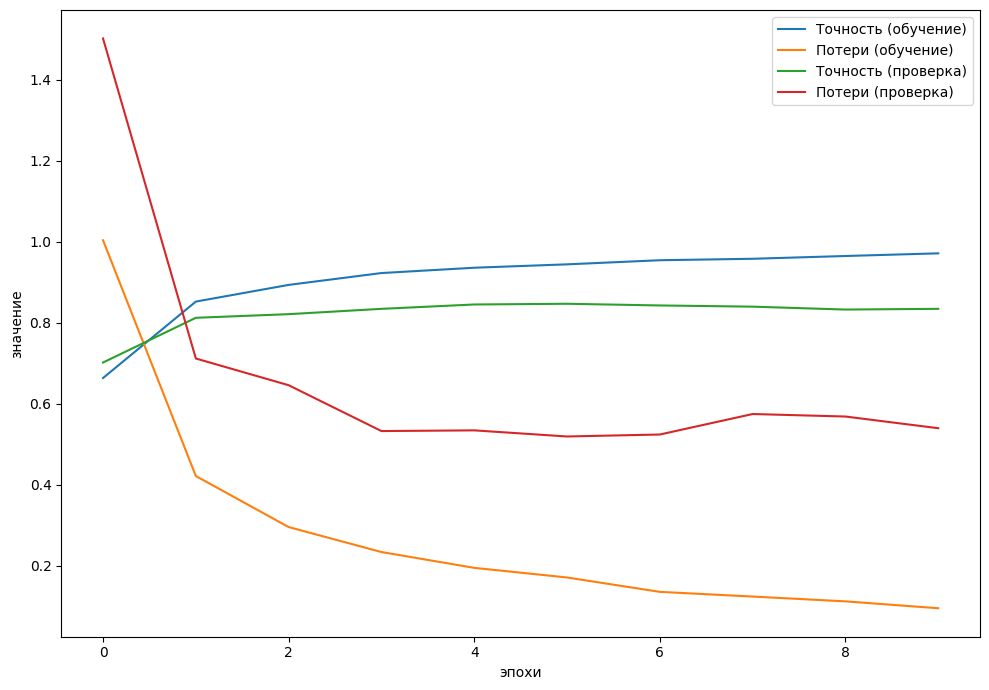

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_10 (TFOpL  (None, 299, 299, 3)       0         
 ambda)                                                          
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                          

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/15
18/18 [==============================] - 14s 416ms/step - loss: 0.9782 - accuracy: 0.6801 - val_loss: 0.8355 - val_accuracy: 0.7710
Epoch 2/15
18/18 [==============================] - 5s 310ms/step - loss: 0.4208 - accuracy: 0.8548 - val_loss: 0.5242 - val_accuracy: 0.8444
Epoch 3/15
18/18 [==============================] - 5s 303ms/step - loss: 0.2870 - accuracy: 0.8996 - val_loss: 0.5173 - val_accuracy: 0.8444
Epoch 4/15
18/18 [==============================] - 5s 306ms/step - loss: 0.1943 - accuracy: 0.9355 - val_loss: 0.5697 - val_accuracy: 0.8265
Epoch 5/15
18/18 [==============================] - 5s 305ms/step - loss: 0.1838 - accuracy: 0.9435 - val_loss: 0.6499 - val_accuracy: 0.8157
Epoch 6/15
18/18 [==============================] - 5s 306ms/step - loss: 0.1647 - accuracy: 0.9498 - val_loss: 0.5968 - val_accuracy: 0.8247
Epoch 7/15
18/18 [==============================] - 5s 309ms/step - loss: 0.1534 - accuracy: 0.9418 - val_loss: 0.5677 - val_accuracy: 0.8318
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/15
18/18 [==============================] - 13s 409ms/step - loss: 1.0730 - accuracy: 0.6437 - val_loss: 1.2868 - val_accuracy: 0.6989
Epoch 2/15
18/18 [==============================] - 6s 350ms/step - loss: 0.4320 - accuracy: 0.8612 - val_loss: 0.4976 - val_accuracy: 0.8799
Epoch 3/15
18/18 [==============================] - 5s 310ms/step - loss: 0.3073 - accuracy: 0.8908 - val_loss: 0.5934 - val_accuracy: 0.8280
Epoch 4/15
18/18 [==============================] - 5s 309ms/step - loss: 0.2354 - accuracy: 0.9158 - val_loss: 0.5890 - val_accuracy: 0.8441
Epoch 5/15
18/18 [==============================] - 5s 305ms/step - loss: 0.1905 - accuracy: 0.9302 - val_loss: 0.5050 - val_accuracy: 0.8405
Epoch 6/15
18/18 [==============================] - 5s 307ms/step - loss: 0.1316 - accuracy: 0.9552 - val_loss: 0.4630 - val_accuracy: 0.8459
Epoch 7/15
18/18 [==============================] - 5s 304ms/step - loss: 0.1167 - accuracy: 0.9642 - val_loss: 0.3905 - val_accuracy: 0.8925
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/15
18/18 [==============================] - 13s 401ms/step - loss: 1.0501 - accuracy: 0.6446 - val_loss: 1.1344 - val_accuracy: 0.6971
Epoch 2/15
18/18 [==============================] - 5s 298ms/step - loss: 0.4098 - accuracy: 0.8648 - val_loss: 1.0231 - val_accuracy: 0.7616
Epoch 3/15
18/18 [==============================] - 5s 300ms/step - loss: 0.2796 - accuracy: 0.9042 - val_loss: 0.6167 - val_accuracy: 0.7993
Epoch 4/15
18/18 [==============================] - 5s 300ms/step - loss: 0.2479 - accuracy: 0.9167 - val_loss: 0.7952 - val_accuracy: 0.7742
Epoch 5/15
18/18 [==============================] - 5s 299ms/step - loss: 0.1882 - accuracy: 0.9355 - val_loss: 0.6307 - val_accuracy: 0.8262
Epoch 6/15
18/18 [==============================] - 5s 302ms/step - loss: 0.1364 - accuracy: 0.9508 - val_loss: 0.4561 - val_accuracy: 0.8728
Epoch 7/15
18/18 [==============================] - 5s 301ms/step - loss: 0.1286 - accuracy: 0.9517 - val_loss: 0.6486 - val_accuracy: 0.8208
Epoch

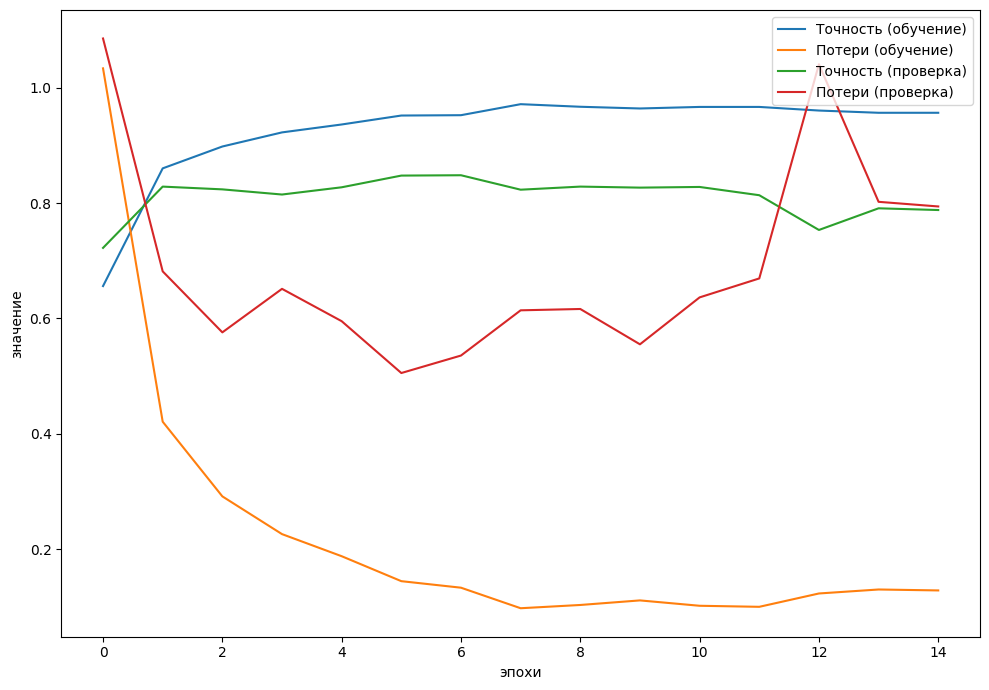

In [14]:
for epochs in [5, 10, 15]:
    test_results = test_training(learning_rate=0.01, epochs=epochs)
    draw_test_results(test_results)

2024-01-15 11:51:00.120232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 11:51:00.490132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 11:51:00.490234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 11:51:00.491912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 11:51:00.492026: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10


2024-01-15 11:51:11.672453: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-15 11:51:12.119252: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-15 11:51:21.876883: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-15 11:51:23.398605: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbbb522aa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 11:51:23.398659: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-01-15 11:51:23.432241: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705290683.588496    5178 device_compiler.

18/18 [==============================] - 36s 1s/step - loss: 1.0669 - accuracy: 0.6487 - val_loss: 1.2251 - val_accuracy: 0.6852
Epoch 2/10
18/18 [==============================] - 5s 298ms/step - loss: 0.5121 - accuracy: 0.8145 - val_loss: 0.6043 - val_accuracy: 0.8354
Epoch 3/10
18/18 [==============================] - 5s 299ms/step - loss: 0.3230 - accuracy: 0.8835 - val_loss: 0.4589 - val_accuracy: 0.8658
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2351 - accuracy: 0.9310 - val_loss: 0.4887 - val_accuracy: 0.8497
Epoch 5/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2035 - accuracy: 0.9310 - val_loss: 0.4219 - val_accuracy: 0.8551
Epoch 6/10
18/18 [==============================] - 5s 298ms/step - loss: 0.1569 - accuracy: 0.9453 - val_loss: 0.4137 - val_accuracy: 0.8694
Epoch 7/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1438 - accuracy: 0.9534 - val_loss: 0.6422 - val_accuracy: 0.8032
Epoch 8/10
18/18 [=

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 24s 1s/step - loss: 1.0087 - accuracy: 0.6688 - val_loss: 1.0553 - val_accuracy: 0.7742
Epoch 2/10
18/18 [==============================] - 5s 298ms/step - loss: 0.4091 - accuracy: 0.8603 - val_loss: 0.6234 - val_accuracy: 0.8423
Epoch 3/10
18/18 [==============================] - 5s 308ms/step - loss: 0.2997 - accuracy: 0.8926 - val_loss: 0.9034 - val_accuracy: 0.7581
Epoch 4/10
18/18 [==============================] - 5s 302ms/step - loss: 0.2357 - accuracy: 0.9284 - val_loss: 0.4681 - val_accuracy: 0.8584
Epoch 5/10
18/18 [==============================] - 5s 311ms/step - loss: 0.1921 - accuracy: 0.9472 - val_loss: 0.5390 - val_accuracy: 0.8584
Epoch 6/10
18/18 [==============================] - 5s 302ms/step - loss: 0.1647 - accuracy: 0.9436 - val_loss: 0.4224 - val_accuracy: 0.8656
Epoch 7/10
18/18 [==============================] - 5s 304ms/step - loss: 0.1605 - accuracy: 0.9490 - val_loss: 0.5167 - val_accuracy: 0.8495
Epoch 8/

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 406ms/step - loss: 1.0447 - accuracy: 0.6428 - val_loss: 1.2686 - val_accuracy: 0.7401
Epoch 2/10
18/18 [==============================] - 5s 302ms/step - loss: 0.4133 - accuracy: 0.8523 - val_loss: 0.7712 - val_accuracy: 0.8100
Epoch 3/10
18/18 [==============================] - 5s 299ms/step - loss: 0.3220 - accuracy: 0.8979 - val_loss: 0.7074 - val_accuracy: 0.8118
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2236 - accuracy: 0.9221 - val_loss: 0.8100 - val_accuracy: 0.8047
Epoch 5/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1853 - accuracy: 0.9391 - val_loss: 0.4852 - val_accuracy: 0.8495
Epoch 6/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1489 - accuracy: 0.9561 - val_loss: 0.5902 - val_accuracy: 0.8387
Epoch 7/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1297 - accuracy: 0.9606 - val_loss: 0.6498 - val_accuracy: 0.8154
Epoch

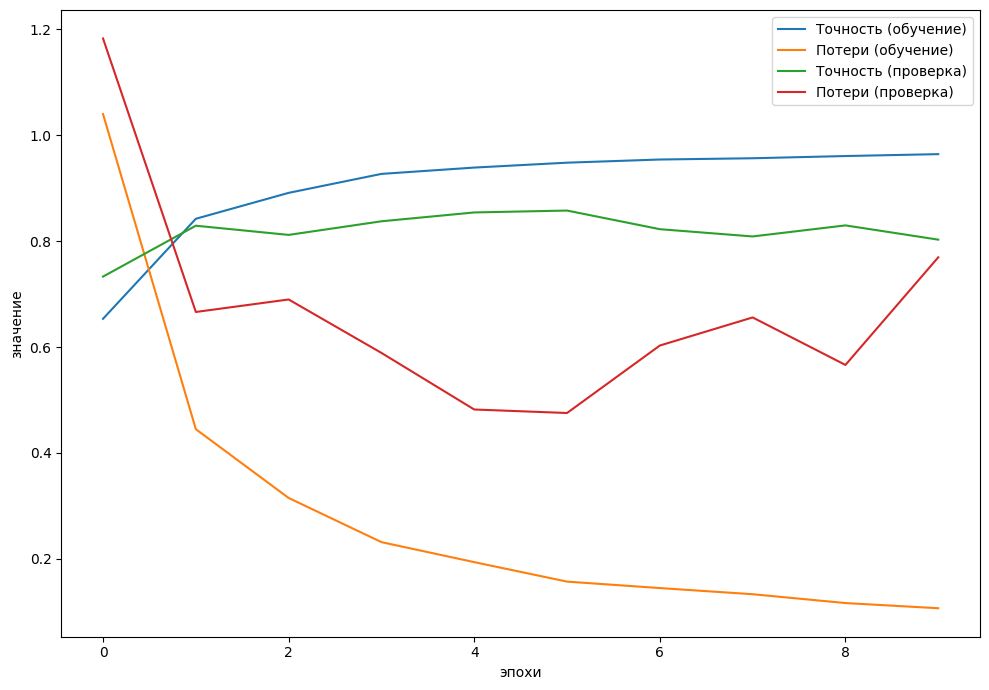

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 422ms/step - loss: 1.1571 - accuracy: 0.6353 - val_loss: 1.0909 - val_accuracy: 0.6547
Epoch 2/10
18/18 [==============================] - 5s 308ms/step - loss: 0.4396 - accuracy: 0.8629 - val_loss: 0.6761 - val_accuracy: 0.7943
Epoch 3/10
18/18 [==============================] - 5s 300ms/step - loss: 0.3213 - accuracy: 0.9050 - val_loss: 0.5556 - val_accuracy: 0.8372
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2311 - accuracy: 0.9301 - val_loss: 0.4307 - val_accuracy: 0.8891
Epoch 5/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1786 - accuracy: 0.9561 - val_loss: 0.4346 - val_accuracy: 0.8891
Epoch 6/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1286 - accuracy: 0.9731 - val_loss: 0.3946 - val_accuracy: 0.8998
Epoch 7/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1001 - accuracy: 0.9830 - val_loss: 0.3916 - val_accuracy: 0.8909
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 414ms/step - loss: 1.1576 - accuracy: 0.6222 - val_loss: 0.8792 - val_accuracy: 0.7527
Epoch 2/10
18/18 [==============================] - 5s 299ms/step - loss: 0.4449 - accuracy: 0.8621 - val_loss: 0.6148 - val_accuracy: 0.8333
Epoch 3/10
18/18 [==============================] - 5s 300ms/step - loss: 0.2834 - accuracy: 0.9176 - val_loss: 0.5464 - val_accuracy: 0.8530
Epoch 4/10
18/18 [==============================] - 5s 300ms/step - loss: 0.2238 - accuracy: 0.9311 - val_loss: 0.5212 - val_accuracy: 0.8548
Epoch 5/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1616 - accuracy: 0.9651 - val_loss: 0.4752 - val_accuracy: 0.8710
Epoch 6/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1203 - accuracy: 0.9740 - val_loss: 0.4601 - val_accuracy: 0.8710
Epoch 7/10
18/18 [==============================] - 5s 302ms/step - loss: 0.1044 - accuracy: 0.9785 - val_loss: 0.4535 - val_accuracy: 0.8584
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 428ms/step - loss: 1.1250 - accuracy: 0.6526 - val_loss: 0.8594 - val_accuracy: 0.7294
Epoch 2/10
18/18 [==============================] - 5s 299ms/step - loss: 0.3953 - accuracy: 0.8756 - val_loss: 0.6231 - val_accuracy: 0.8244
Epoch 3/10
18/18 [==============================] - 5s 298ms/step - loss: 0.2635 - accuracy: 0.9221 - val_loss: 0.5664 - val_accuracy: 0.8351
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1890 - accuracy: 0.9561 - val_loss: 0.5005 - val_accuracy: 0.8710
Epoch 5/10
18/18 [==============================] - 5s 302ms/step - loss: 0.1366 - accuracy: 0.9740 - val_loss: 0.5063 - val_accuracy: 0.8477
Epoch 6/10
18/18 [==============================] - 5s 301ms/step - loss: 0.1135 - accuracy: 0.9705 - val_loss: 0.4845 - val_accuracy: 0.8674
Epoch 7/10
18/18 [==============================] - 5s 302ms/step - loss: 0.0856 - accuracy: 0.9919 - val_loss: 0.4360 - val_accuracy: 0.8746
Epoch

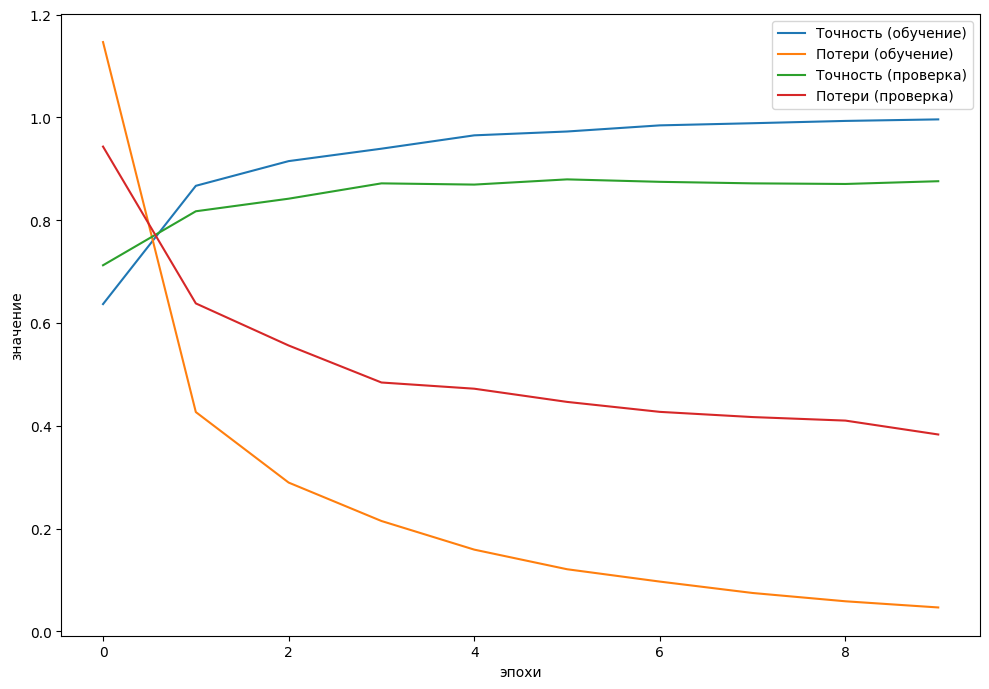

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 424ms/step - loss: 2.4104 - accuracy: 0.2697 - val_loss: 2.0542 - val_accuracy: 0.3524
Epoch 2/10
18/18 [==============================] - 5s 302ms/step - loss: 1.2680 - accuracy: 0.5905 - val_loss: 1.7302 - val_accuracy: 0.5599
Epoch 3/10
18/18 [==============================] - 5s 303ms/step - loss: 0.8753 - accuracy: 0.7294 - val_loss: 1.5020 - val_accuracy: 0.6941
Epoch 4/10
18/18 [==============================] - 5s 300ms/step - loss: 0.6631 - accuracy: 0.8154 - val_loss: 1.3348 - val_accuracy: 0.7657
Epoch 5/10
18/18 [==============================] - 5s 301ms/step - loss: 0.5698 - accuracy: 0.8315 - val_loss: 1.1904 - val_accuracy: 0.8014
Epoch 6/10
18/18 [==============================] - 5s 300ms/step - loss: 0.4827 - accuracy: 0.8620 - val_loss: 1.0933 - val_accuracy: 0.7979
Epoch 7/10
18/18 [==============================] - 5s 303ms/step - loss: 0.4298 - accuracy: 0.8844 - val_loss: 0.9857 - val_accuracy: 0.8354
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 15s 410ms/step - loss: 2.1273 - accuracy: 0.3259 - val_loss: 1.9146 - val_accuracy: 0.4606
Epoch 2/10
18/18 [==============================] - 5s 298ms/step - loss: 1.1762 - accuracy: 0.6186 - val_loss: 1.5956 - val_accuracy: 0.6541
Epoch 3/10
18/18 [==============================] - 5s 302ms/step - loss: 0.8358 - accuracy: 0.7422 - val_loss: 1.3904 - val_accuracy: 0.7814
Epoch 4/10
18/18 [==============================] - 5s 300ms/step - loss: 0.6455 - accuracy: 0.8183 - val_loss: 1.2457 - val_accuracy: 0.8226
Epoch 5/10
18/18 [==============================] - 5s 299ms/step - loss: 0.5264 - accuracy: 0.8514 - val_loss: 1.1172 - val_accuracy: 0.8495
Epoch 6/10
18/18 [==============================] - 5s 301ms/step - loss: 0.4285 - accuracy: 0.8791 - val_loss: 1.0190 - val_accuracy: 0.8423
Epoch 7/10
18/18 [==============================] - 5s 299ms/step - loss: 0.4007 - accuracy: 0.8917 - val_loss: 0.9277 - val_accuracy: 0.8477
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 12s 409ms/step - loss: 2.1706 - accuracy: 0.2919 - val_loss: 1.9627 - val_accuracy: 0.4498
Epoch 2/10
18/18 [==============================] - 5s 298ms/step - loss: 1.1882 - accuracy: 0.6258 - val_loss: 1.6391 - val_accuracy: 0.6362
Epoch 3/10
18/18 [==============================] - 5s 298ms/step - loss: 0.8300 - accuracy: 0.7484 - val_loss: 1.4428 - val_accuracy: 0.7133
Epoch 4/10
18/18 [==============================] - 5s 303ms/step - loss: 0.6566 - accuracy: 0.8057 - val_loss: 1.3022 - val_accuracy: 0.7616
Epoch 5/10
18/18 [==============================] - 5s 305ms/step - loss: 0.5587 - accuracy: 0.8433 - val_loss: 1.1903 - val_accuracy: 0.7796
Epoch 6/10
18/18 [==============================] - 5s 300ms/step - loss: 0.4690 - accuracy: 0.8747 - val_loss: 1.0836 - val_accuracy: 0.8029
Epoch 7/10
18/18 [==============================] - 5s 298ms/step - loss: 0.4127 - accuracy: 0.8935 - val_loss: 0.9831 - val_accuracy: 0.8100
Epoch

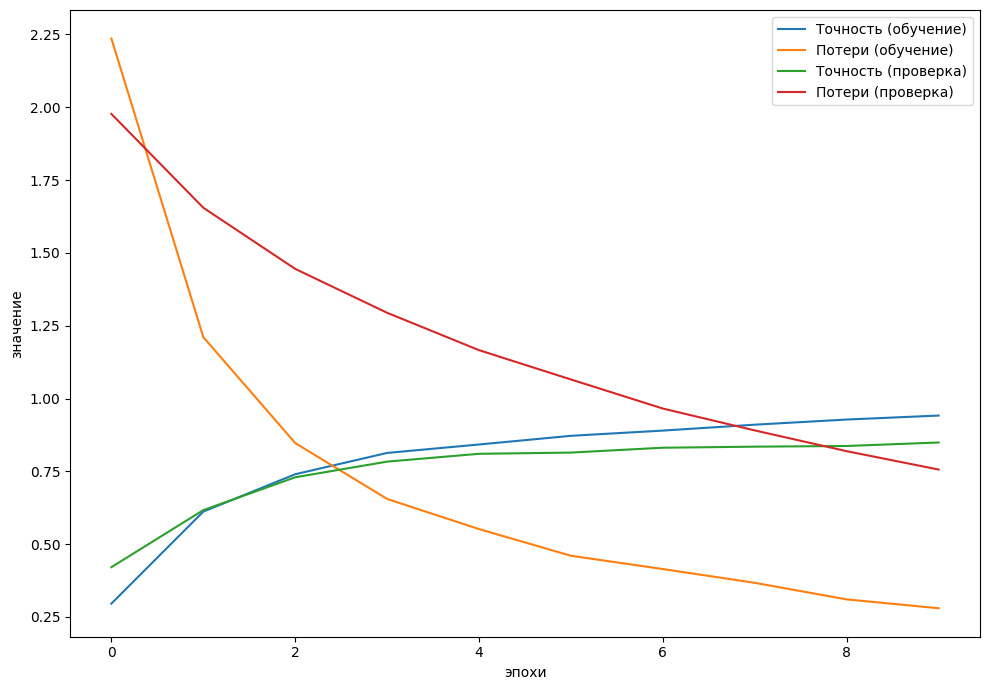

In [11]:
for lr in [0.01, 0.001, 0.0001]:
    test_results = test_training(learning_rate=lr, epochs=10)
    draw_test_results(test_results)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_9 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_9 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 15s 408ms/step - loss: 1.1472 - accuracy: 0.6389 - val_loss: 1.0447 - val_accuracy: 0.6279
Epoch 2/10
18/18 [==============================] - 5s 299ms/step - loss: 0.4735 - accuracy: 0.8513 - val_loss: 0.5748 - val_accuracy: 0.8265
Epoch 3/10
18/18 [==============================] - 5s 304ms/step - loss: 0.3139 - accuracy: 0.9023 - val_loss: 0.4846 - val_accuracy: 0.8658
Epoch 4/10
18/18 [==============================] - 5s 303ms/step - loss: 0.2116 - accuracy: 0.9525 - val_loss: 0.4319 - val_accuracy: 0.8909
Epoch 5/10
18/18 [==============================] - 5s 297ms/step - loss: 0.1775 - accuracy: 0.9534 - val_loss: 0.4275 - val_accuracy: 0.8891
Epoch 6/10
18/18 [==============================] - 5s 295ms/step - loss: 0.1218 - accuracy: 0.9785 - val_loss: 0.3838 - val_accuracy: 0.8927
Epoch 7/10
18/18 [==============================] - 5s 296ms/step - loss: 0.0964 - accuracy: 0.9875 - val_loss: 0.3691 - val_accuracy: 0.8962
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 406ms/step - loss: 1.0609 - accuracy: 0.6428 - val_loss: 0.9712 - val_accuracy: 0.7097
Epoch 2/10
18/18 [==============================] - 5s 300ms/step - loss: 0.3855 - accuracy: 0.8827 - val_loss: 0.6710 - val_accuracy: 0.8011
Epoch 3/10
18/18 [==============================] - 5s 298ms/step - loss: 0.2736 - accuracy: 0.9239 - val_loss: 0.5861 - val_accuracy: 0.8262
Epoch 4/10
18/18 [==============================] - 5s 298ms/step - loss: 0.1915 - accuracy: 0.9508 - val_loss: 0.5057 - val_accuracy: 0.8620
Epoch 5/10
18/18 [==============================] - 5s 298ms/step - loss: 0.1516 - accuracy: 0.9678 - val_loss: 0.4996 - val_accuracy: 0.8477
Epoch 6/10
18/18 [==============================] - 5s 304ms/step - loss: 0.1142 - accuracy: 0.9785 - val_loss: 0.4814 - val_accuracy: 0.8656
Epoch 7/10
18/18 [==============================] - 6s 313ms/step - loss: 0.0836 - accuracy: 0.9875 - val_loss: 0.4944 - val_accuracy: 0.8656
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 13s 432ms/step - loss: 1.2151 - accuracy: 0.5944 - val_loss: 0.9347 - val_accuracy: 0.6971
Epoch 2/10
18/18 [==============================] - 5s 294ms/step - loss: 0.4111 - accuracy: 0.8863 - val_loss: 0.7260 - val_accuracy: 0.7419
Epoch 3/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2833 - accuracy: 0.9185 - val_loss: 0.5584 - val_accuracy: 0.8459
Epoch 4/10
18/18 [==============================] - 5s 305ms/step - loss: 0.2102 - accuracy: 0.9427 - val_loss: 0.5416 - val_accuracy: 0.8513
Epoch 5/10
18/18 [==============================] - 5s 308ms/step - loss: 0.1623 - accuracy: 0.9579 - val_loss: 0.5242 - val_accuracy: 0.8548
Epoch 6/10
18/18 [==============================] - 5s 311ms/step - loss: 0.1104 - accuracy: 0.9758 - val_loss: 0.4775 - val_accuracy: 0.8333
Epoch 7/10
18/18 [==============================] - 5s 311ms/step - loss: 0.1006 - accuracy: 0.9812 - val_loss: 0.4554 - val_accuracy: 0.8656
Epoch

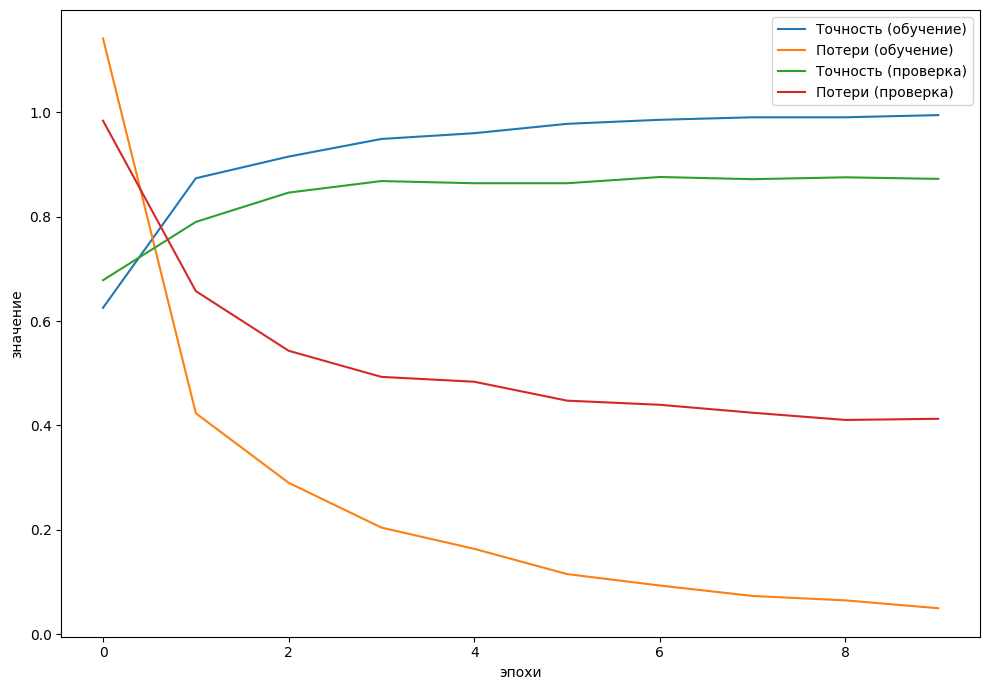

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_12 (TFOpL  (None, 299, 299, 3)       0         
 ambda)                                                          
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                          

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 12s 406ms/step - loss: 1.2909 - accuracy: 0.5780 - val_loss: 1.0782 - val_accuracy: 0.6440
Epoch 2/10
18/18 [==============================] - 5s 298ms/step - loss: 0.4886 - accuracy: 0.8495 - val_loss: 0.6720 - val_accuracy: 0.8372
Epoch 3/10
18/18 [==============================] - 5s 298ms/step - loss: 0.3492 - accuracy: 0.8934 - val_loss: 0.5560 - val_accuracy: 0.8497
Epoch 4/10
18/18 [==============================] - 5s 298ms/step - loss: 0.2705 - accuracy: 0.9220 - val_loss: 0.4911 - val_accuracy: 0.8748
Epoch 5/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2154 - accuracy: 0.9462 - val_loss: 0.4489 - val_accuracy: 0.8766
Epoch 6/10
18/18 [==============================] - 5s 300ms/step - loss: 0.1497 - accuracy: 0.9758 - val_loss: 0.4376 - val_accuracy: 0.8784
Epoch 7/10
18/18 [==============================] - 5s 298ms/step - loss: 0.1216 - accuracy: 0.9776 - val_loss: 0.4288 - val_accuracy: 0.8855
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 12s 400ms/step - loss: 1.2352 - accuracy: 0.5882 - val_loss: 0.8991 - val_accuracy: 0.7330
Epoch 2/10
18/18 [==============================] - 5s 298ms/step - loss: 0.4783 - accuracy: 0.8702 - val_loss: 0.5839 - val_accuracy: 0.8602
Epoch 3/10
18/18 [==============================] - 5s 299ms/step - loss: 0.3249 - accuracy: 0.9069 - val_loss: 0.5235 - val_accuracy: 0.8513
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2445 - accuracy: 0.9311 - val_loss: 0.5118 - val_accuracy: 0.8853
Epoch 5/10
18/18 [==============================] - 5s 300ms/step - loss: 0.2101 - accuracy: 0.9409 - val_loss: 0.4764 - val_accuracy: 0.8566
Epoch 6/10
18/18 [==============================] - 5s 301ms/step - loss: 0.1744 - accuracy: 0.9633 - val_loss: 0.4769 - val_accuracy: 0.8548
Epoch 7/10
18/18 [==============================] - 5s 302ms/step - loss: 0.1450 - accuracy: 0.9687 - val_loss: 0.4535 - val_accuracy: 0.8674
Epoch

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
18/18 [==============================] - 15s 433ms/step - loss: 1.3031 - accuracy: 0.5828 - val_loss: 0.9732 - val_accuracy: 0.7151
Epoch 2/10
18/18 [==============================] - 5s 308ms/step - loss: 0.5261 - accuracy: 0.8353 - val_loss: 0.6287 - val_accuracy: 0.8208
Epoch 3/10
18/18 [==============================] - 5s 299ms/step - loss: 0.3689 - accuracy: 0.8908 - val_loss: 0.5330 - val_accuracy: 0.8423
Epoch 4/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2774 - accuracy: 0.9087 - val_loss: 0.4835 - val_accuracy: 0.8638
Epoch 5/10
18/18 [==============================] - 5s 299ms/step - loss: 0.2081 - accuracy: 0.9427 - val_loss: 0.4544 - val_accuracy: 0.8656
Epoch 6/10
18/18 [==============================] - 5s 299ms/step - loss: 0.1878 - accuracy: 0.9534 - val_loss: 0.4414 - val_accuracy: 0.8710
Epoch 7/10
18/18 [==============================] - 5s 307ms/step - loss: 0.1653 - accuracy: 0.9579 - val_loss: 0.4330 - val_accuracy: 0.8799
Epoch

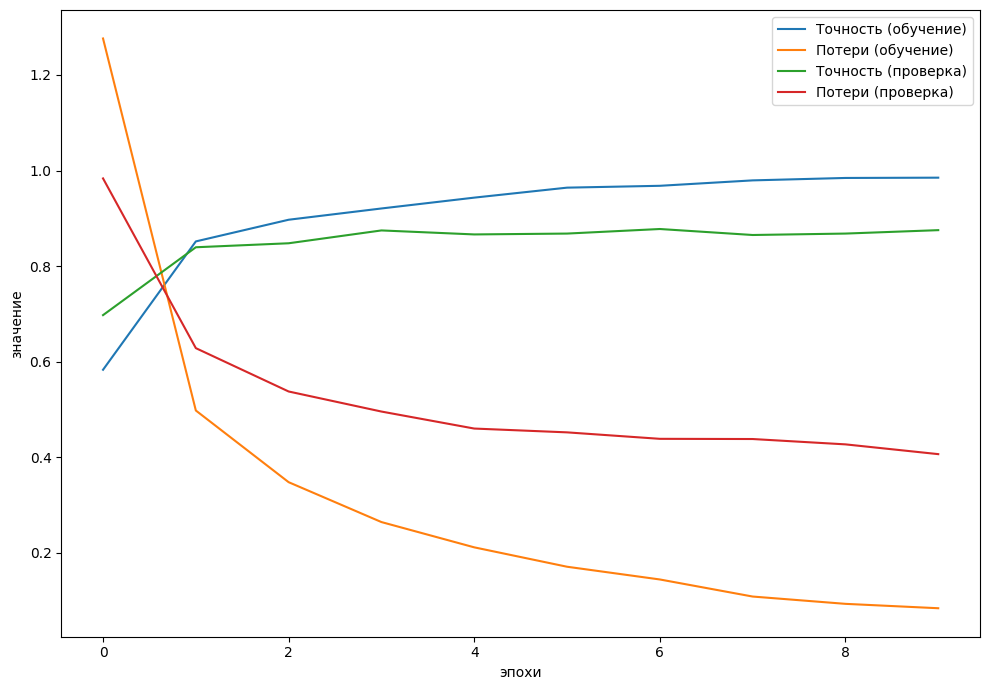

In [12]:
for dropout in [0.25, 0.35]:
    test_results = test_training(learning_rate=0.001, epochs=10, dropout=dropout)
    draw_test_results(test_results)

In [7]:
from sklearn import metrics
def draw_confusion_matrix(y_test, y_pred_id):
    cm = metrics.confusion_matrix(y_test, y_pred_id)

    _, ax = plt.subplots(figsize= (10, 10))

    ax.imshow(cm)

    ax.set_xticks(range(0, CLASSES_NUM))
    ax.set_yticks(range(0, CLASSES_NUM))

    ax.set_yticklabels(BREEDS)
    ax.set_xticklabels(BREEDS, rotation='vertical')

    plt.xlabel('Предсказанния')
    plt.ylabel('Ответы')
    plt.title('Матрица ошибок ', size='xx-large')
    plt.show()

In [8]:
def getCorrect(test, predict):
    n = len(test)
    correct = 0
    for i in range(n):
        correct += (test[i] == predict[i])
    return correct/n

In [9]:
def eval_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    # перевод значени в массиве с горячего кодирования до десятичных чисел
    y_pred_id = [ np.argmax(i)+1 for i in y_pred]

    draw_confusion_matrix(y_test=y_test, y_pred_id=y_pred_id)
    print('Доля правильных ответах на тестовых данные равна:', getCorrect(test=y_test, predict=y_pred_id))

In [10]:
# разморозка последних слоев модели
# fine_tune_at с какого слоя начинается разморозка
def unfreeze(model, fine_tune_at=208):
    for layer in model.layers:
        if layer.name == 'inception_v3':
            layer.trainable = True
             # заморозка всех слоев до fine_tune_at
            for sublayer in layer.layers[:fine_tune_at]:
                sublayer.trainable =  False
            break
    return model

In [11]:
def fine_tuning(model, x_train, y_train, initial_epochs, fine_tune_epochs, learning_rate=0.0001, fine_tune_at=208):
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=64, initial_epoch=initial_epochs, epochs=initial_epochs+fine_tune_epochs, validation_split=0.3)
    return model

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_7 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_7 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
27/27 [==============================] - 11s 196ms/step - loss: 1.0337 - accuracy: 0.6591
Epoch 2/10
27/27 [==============================] - 5s 194ms/step - loss: 0.4214 - accuracy: 0.8675
Epoch 3/10
27/27 [==============================] - 5s 196ms/step - loss: 0.3174 - accuracy: 0.9045
Epoch 4/10
27/27 [==============================] - 5s 196ms/step - loss: 0.2405 - accuracy: 0.9391
Epoch 5/10
27/27 [==============================] - 5s 196ms/step - loss: 0.1999 - accuracy: 0.9451
Epoch 6/10
27/27 [==============================] - 5s 196ms/step - loss: 0.1724 - accuracy: 0.9552
Epoch 7/10
27/27 [==============================] - 5s 196ms/step - loss: 0.1559 - accuracy: 0.9594
Epoch 8/10
27/27 [==============================] - 5s 196ms/step - loss: 0.1322 - accuracy: 0.9737
Epoch 9/10
27/27 [==============================] - 5s 196ms/step - loss: 0.1067 - accuracy: 0.9779
Epoch 10/10
23/23 [==============================] - 4s 103ms/step


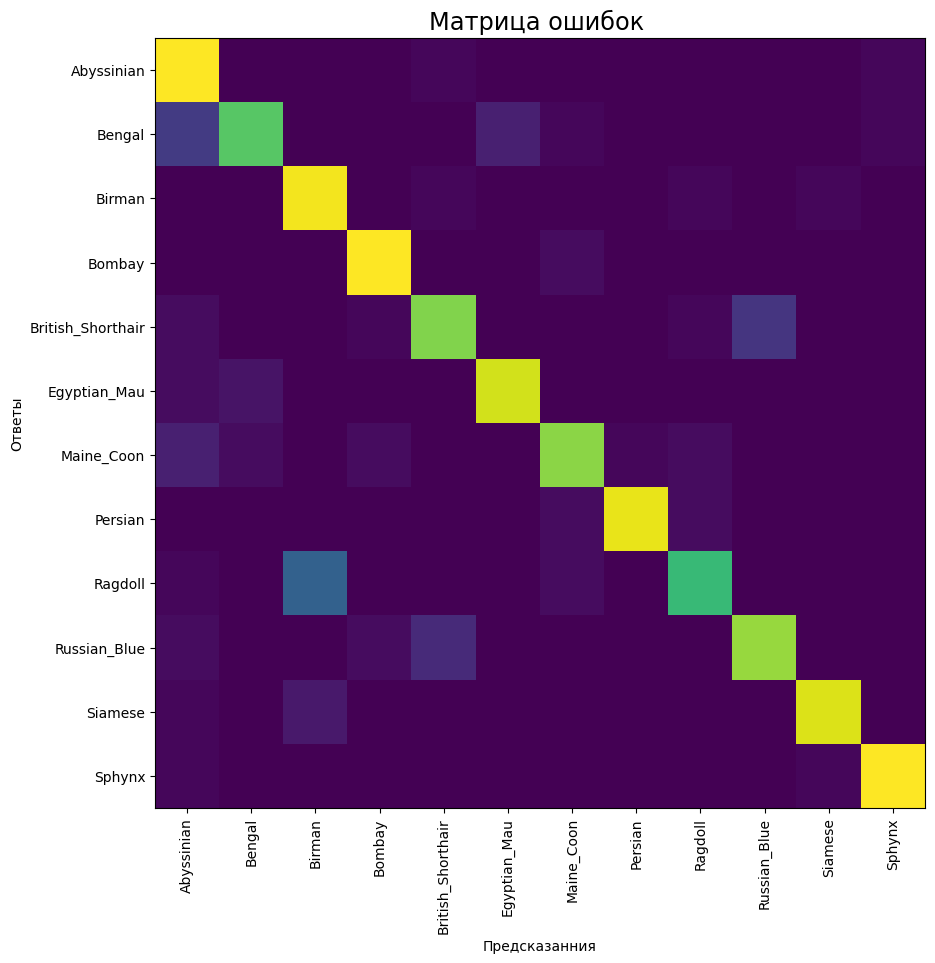

Доля правильных ответах на тестовых данные равна: 0.8650904033379694


In [26]:
model = createModel(learning_rate=0.001, dropout=0.35)

model.fit(x_train, onehotencode(y_train), batch_size=64, epochs=10)

eval_model(model, x_test, y_test)

/home/rou/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 11/13
19/19 [==============================] - 19s 487ms/step - loss: 0.0766 - accuracy: 0.9855 - val_loss: 0.0703 - val_accuracy: 0.9980
Epoch 12/13
19/19 [==============================] - 7s 385ms/step - loss: 0.0481 - accuracy: 0.9949 - val_loss: 0.0679 - val_accuracy: 0.9960
Epoch 13/13
23/23 [==============================] - 4s 103ms/step


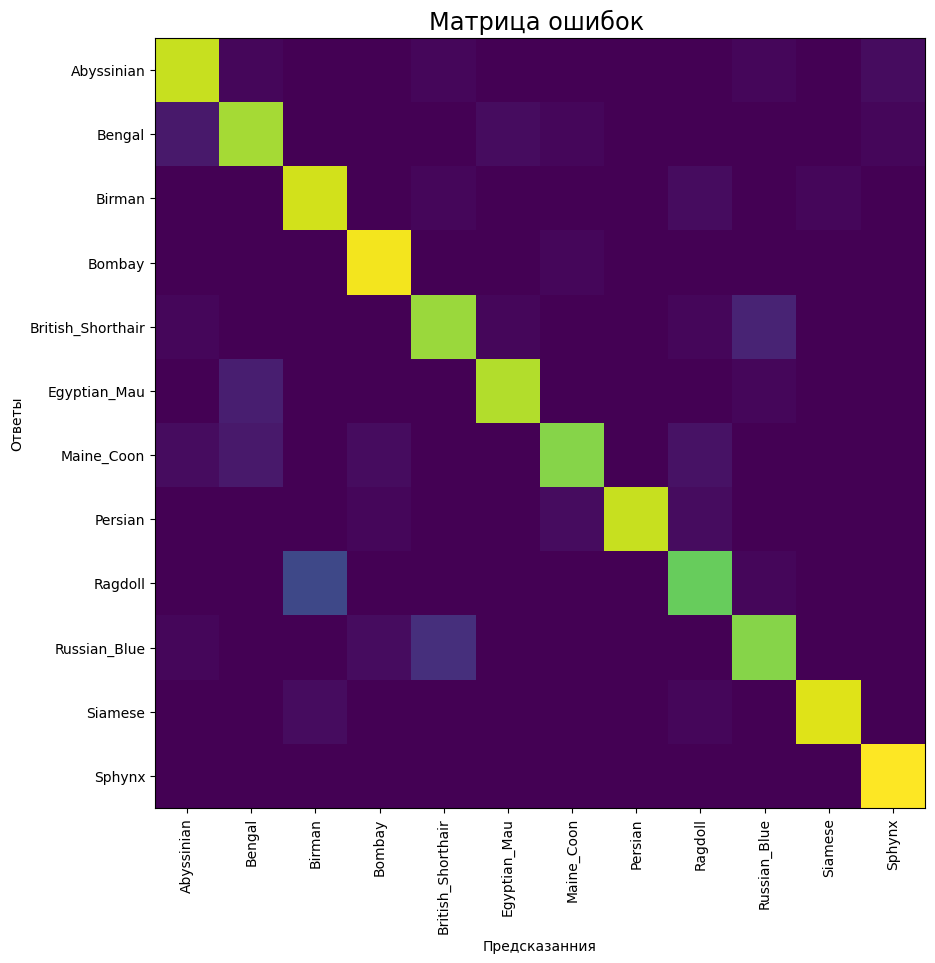

Доля правильных ответах на тестовых данные равна: 0.8929068150208623


In [27]:
model = unfreeze(model=model)

model = fine_tuning(model=model, x_train=x_train, y_train=onehotencode(y_train), initial_epochs=10, fine_tune_epochs=3, learning_rate=0.00001)

eval_model(model, x_test, y_test)

In [28]:
# сохранение модели
model.save('my_model.h5')

/home/rou/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# сохранение словаря с отношением id - порода в формате json
import json

id_to_breed = {}
for id in data_breed:
    id_to_breed[id] = data_breed[id]['breed']

with open('data/id_to_breed.json', 'w') as f:
    json.dump(id_to_breed, f)

: 